The data for this analysis was collected by running

```bash
python ../../examples/takeover_times.py > fitness_pop50_parents.csv
```

with `ops.random_selection` in the `reproduction_pipeline` argument (i.e. random parent selection from the population) and then

```bash
python ../../examples/takeover_times.py > fitness_pop50_parents+processing.csv
```

after editing it to use `co.select_with_processing(ops.random_selection, eval_cluster)` instead (i.e. the ProSelect parent selection strategy).

The results were then collated into a combined CSV file via

```bash
python -m leap_ec.contrib.analysis analyze fitness_pop50*
```

Then renamed

```bash
mv curves_combined.csv curves_combined_pop50.csv
```

In [1]:
%matplotlib inline
import os

from leap_ec.probe import FitnessStatsCSVProbe
from leap_ec.contrib import analysis
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use('ggplot')

In [2]:
!mkdir -p ./figures

In [3]:
def load_data(curves_file, modulo=1, time_col='step', max_time=float('Inf')):
    assert(os.path.exists(curves_file))
    df = pd.read_csv(curves_file, skipinitialspace=True, comment='#')
    df = df[df[time_col] % modulo == 0]  # Select every nth step
    df = df[df[time_col] < max_time]  # Cut off end of runs
    
    df.experiment = df.experiment.replace('select(parents)', 'Basic Async')
    df.experiment = df.experiment.replace('select(parents+processing)', 'SWEET')
    return df

In [4]:
def plot_all(df, time_col='step', metric_col='bsf', metric_cols=(),
             ylim=(None, None), error=True, ylog=False):
    
    analyzer = analysis.CurveAnalyzer(df,
                                      time_col=time_col,
                                      experiment_cols=['experiment'],
                                      metric_cols=FitnessStatsCSVProbe.default_metric_cols + metric_cols)
    plotter = analysis.CurvePlotter(analyzer)

    plt.figure(figsize=(20, 8))
    plt.subplot(131)
    plotter.plot_curves(metric_col, f"Indiviudal {metric_col} Curves", ylog=ylog, ax=plt.gca())
    plt.subplot(132)
    plotter.plot_avg_curves(metric_col, f"Average {metric_col} Curves", error, ylim, ylog=ylog, ax=plt.gca())
    plt.subplot(133)
    plotter.plot_scalars_bar(metric_col, title='Area Under Curve', ax=plt.gca())

In [5]:
def plot_two(df, time_col='step', metric_col='bsf', metric_cols=(),
             ylim=(None, None), error=True, ylog=False):

    analyzer = analysis.CurveAnalyzer(df,
                                      time_col=time_col,
                                      experiment_cols=['experiment'],
                                      metric_cols=FitnessStatsCSVProbe.default_metric_cols + metric_cols)
    plotter = analysis.CurvePlotter(analyzer)

    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plotter.plot_avg_curves(metric_col, f"Average {metric_col} Curves", error, ylim, ylog=ylog, ax=plt.gca())
    plt.subplot(122)
    plotter.plot_scalars_bar(metric_col, title='Area Under Curve', ax=plt.gca())
    plt.xlabel('')
    plt.tight_layout()
    

In [6]:
def plot_bsf(df, time_col='step', metric_col='bsf', metric_cols=(),
             ylim=(None, None), error=True, ylog=False):

    analyzer = analysis.CurveAnalyzer(df,
                                      time_col=time_col,
                                      experiment_cols=['experiment'],
                                      metric_cols=FitnessStatsCSVProbe.default_metric_cols + metric_cols)
    plotter = analysis.CurvePlotter(analyzer)

    plotter.plot_avg_curves(metric_col, f"Average {metric_col} Curves", error, ylim, ylog=ylog, ax=plt.gca())
    

# Takeover Times

In [7]:
df = load_data('./curves_combined_pop50.csv', modulo=250)
df

,Unnamed: 0,experiment,job,step,bsf,mean_fitness,std_fitness,min_fitness,max_fitness,time,birth,mean_eval_time,LOW_ratio,HIGH_ratio
0,0,Basic Async,0,0,0,0.0,0.0,0,0,1,51,1.0,1.0,0.0
25,25,Basic Async,0,250,0,0.0,0.0,0,0,6,301,1.0,1.0,0.0
50,50,Basic Async,0,500,0,0.0,0.0,0,0,11,551,1.0,1.0,0.0
75,75,Basic Async,0,750,0,0.0,0.0,0,0,16,801,1.0,1.0,0.0
100,100,Basic Async,0,1000,0,0.0,0.0,0,0,21,1051,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87528,26860,SWEET,49,4250,100,100.0,0.0,100,100,7908,4301,100.0,0.0,1.0
87553,26885,SWEET,49,4500,100,100.0,0.0,100,100,8408,4551,100.0,0.0,1.0
87578,26910,SWEET,49,4750,100,100.0,0.0,100,100,8908,4801,100.0,0.0,1.0
87603,26935,SWEET,49,5000,100,100.0,0.0,100,100,9408,5051,100.0,0.0,1.0


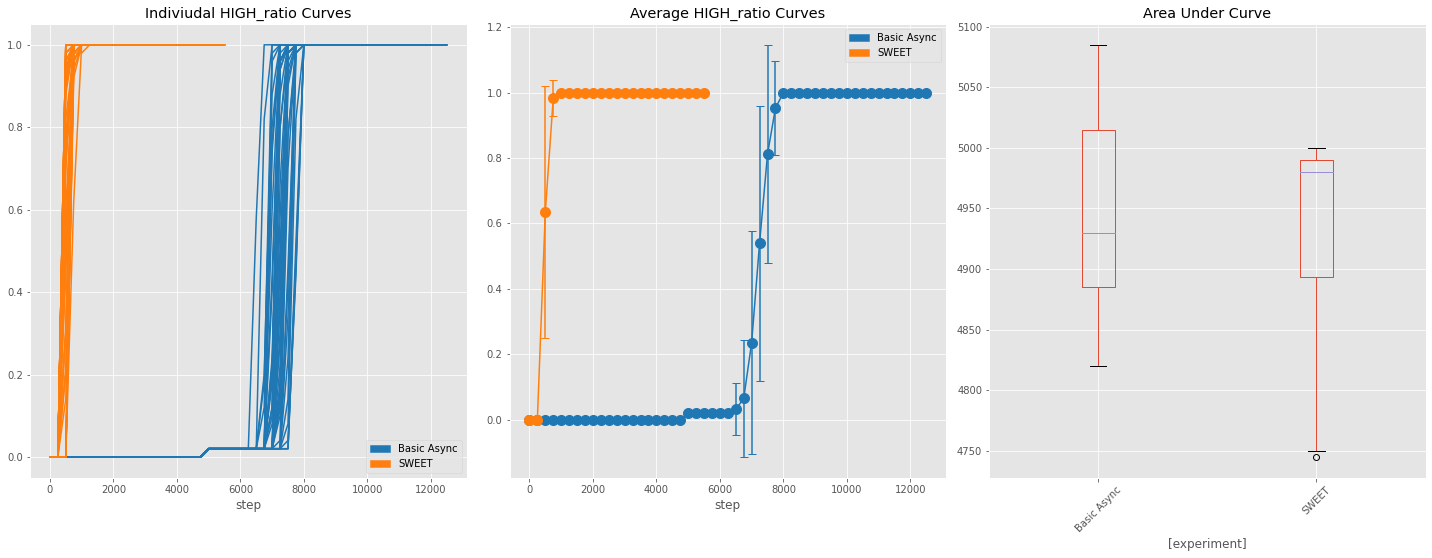

In [8]:
metric_cols = ('mean_eval_time', 'LOW_ratio', 'HIGH_ratio')
plot_all(df, metric_col='HIGH_ratio', metric_cols=metric_cols)

In [9]:
from matplotlib import patches 

df = pd.read_csv('./curves_combined_pop50.csv')
df.experiment = df.experiment.replace('select(parents)', 'Basic Async')
df.experiment = df.experiment.replace('select(parents+processing)', 'SWEET')

def plot_takeover_curves(df):
    df = df[df.time < 1000]

    cmap = plt.get_cmap("tab10")
    legend_patches = []

    for i,(group_key, group_df) in enumerate(df.groupby(['experiment'])):
        patch = patches.Patch(color=cmap(i), label=group_key)
        legend_patches.append(patch)
        group_df.groupby(['job']).plot('time', 'HIGH_ratio', color=cmap(i), ax=plt.gca(), alpha=0.4)


    plt.legend(handles=legend_patches)

In [10]:
convergence_steps = df[df.HIGH_ratio == 1.0].groupby(['experiment', 'job']).step.idxmin()
convergence_steps
conv_df = df.loc[convergence_steps][['experiment', 'job', 'step', 'time']]
conv_df

,experiment,job,step,time
745,Basic Async,0,7450,704
1959,Basic Async,1,7490,511
3151,Basic Async,2,7170,516
4347,Basic Async,3,7230,611
5587,Basic Async,4,7710,812
...,...,...,...,...
85020,SWEET,45,650,507
85550,SWEET,46,550,406
86090,SWEET,47,600,508
86623,SWEET,48,600,407


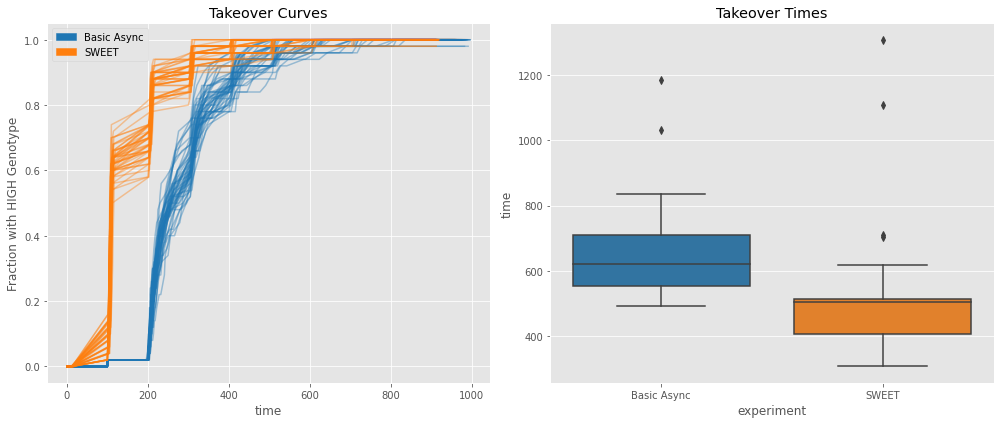

In [18]:
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(121)
plot_takeover_curves(df)
plt.ylabel('Fraction with HIGH Genotype')
plt.title('Takeover Curves')

plt.subplot(122)
#conv_df.boxplot(by='experiment', column='time')
sns.boxplot(x='experiment', y='time', data=conv_df, palette=sns.color_palette("tab10"))
plt.title('Takeover Times')

plt.tight_layout()
plt.savefig('./figures/takeover_times.pdf', format='pdf')

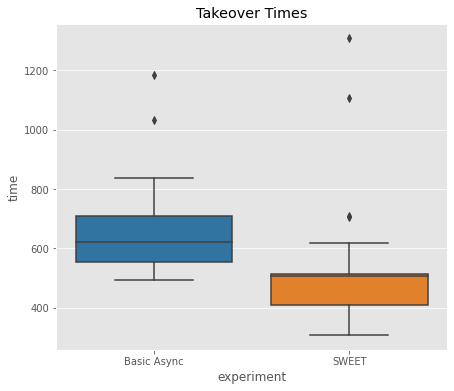

In [17]:
plt.figure(figsize=(7, 6))
sns.boxplot(x='experiment', y='time', data=conv_df, palette=sns.color_palette("tab10"))
plt.title('Takeover Times')
plt.savefig('./figures/takeover_times_by_time_boxplot.pdf', format='pdf')

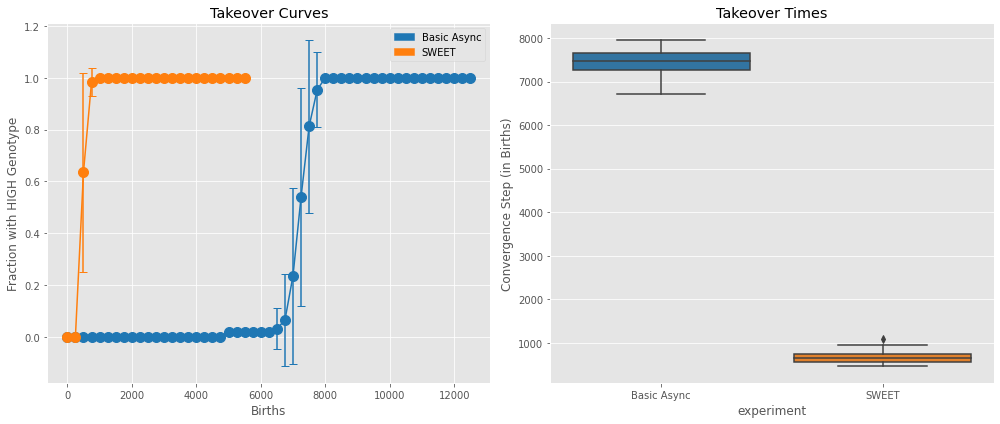

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plot_bsf(df[df.step % 250 == 0], metric_col='HIGH_ratio', metric_cols=metric_cols)
plt.ylabel('Fraction with HIGH Genotype')
plt.title('Takeover Curves')
plt.xlabel('Births')

plt.subplot(122)
#conv_df.boxplot(by='experiment', column='time')
sns.boxplot(x='experiment', y='step', data=conv_df, palette=sns.color_palette("tab10"))
plt.title('Takeover Times')
plt.ylabel('Convergence Step (in Births)')


plt.tight_layout()
plt.savefig('./figures/takeover_times_by_birth.pdf', format='pdf')

(array([11., 19., 12.,  5.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 308. ,  407.9,  507.8,  607.7,  707.6,  807.5,  907.4, 1007.3,
        1107.2, 1207.1, 1307. ]),
 <BarContainer object of 10 artists>)

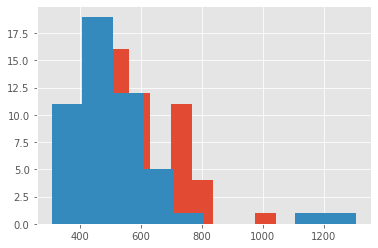

In [13]:
a = conv_df[conv_df.experiment == 'Basic Async'].time.array
b = conv_df[conv_df.experiment == 'SWEET'].time.array
plt.hist(a)
plt.hist(b)

In [14]:
import numpy as np

print(f"Basic Async median: {np.median(a)}")
print(f"SWEET median: {np.median(b)}")

Basic Async median: 621.5
SWEET median: 505.5


In [15]:
from scipy.stats import ranksums

ranksums(a, b)

RanksumsResult(statistic=5.866640714014003, pvalue=4.447128712342298e-09)